In [1]:
# cell 1
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import torchvision.models as models
import pandas as pd
from PIL import Image
import os
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import csv


# --- 函數 1: 繪圖 ---
def plot_loss_curves(history, phase_name):
    """根據訓練歷史數據繪製 Loss 曲線圖"""
    plt.figure(figsize=(10, 6))
    epochs = [h["epoch"] for h in history]

    plt.plot(epochs, [h["train_loss"] for h in history], label="Train Loss", marker="o")
    plt.plot(
        epochs, [h["val_loss"] for h in history], label="Validation Loss", marker="o"
    )

    plt.title(f"ResNet-50 {phase_name}: Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Log Loss")
    plt.xticks(epochs)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()


# --- 函數 2: 驗證 ---
def validate_model(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = corrects.double() / len(dataloader.dataset)

    print(f"Validation Log Loss: {total_loss:.4f} | Acc: {total_acc:.4f}")
    return total_loss, total_acc.item()


# --- 函數 3: 訓練 ---
def train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    dataloader,
    val_loader,
    num_epochs,
    phase="Training",
    device=None,
):

    best_loss = float("inf")

    # 由於模型在 Cell 5 已載入到 GPU，我們只需記錄狀態
    # 這裡省略 model.state_dict()，在函數外部處理儲存

    loss_history = []

    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ({phase}) ---\n")

        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1} {phase}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)

        # 1. 在每個 Epoch 結束後進行驗證 (計算 val_loss)
        val_loss, val_acc = validate_model(model, criterion, val_loader, device)

     
        #2. 根據 val_loss 調整學習率
        if scheduler is not None:
            # 必須在 val_loss 被計算後調用
            scheduler.step(val_loss)

        print(f"{phase} Train Loss: {epoch_loss:.4f}")

        # 3. 記錄當前 Epoch 的結果
        loss_history.append(
            {"epoch": epoch + 1, "train_loss": epoch_loss, "val_loss": val_loss}
        )

        # 4. 僅保存驗證損失最低的模型權重 (Model Checkpoint)
        if val_loss < best_loss:
            best_loss = val_loss
            # 確保儲存路徑是唯一的
            weights_filename = f"resnet50_best_loss_{phase}.pth"
            torch.save(model.state_dict(), weights_filename)
            print(
                f" -> 驗證 Loss 降低 ({best_loss:.4f})，已保存模型到 {weights_filename}！"
            )

    # 訓練結束後繪圖
    plot_loss_curves(loss_history, phase)

    # 載入最佳權重
    model.load_state_dict(torch.load(weights_filename))
    return model

In [ ]:
# cell 2
# --- 配置參數 ---
NUM_CLASSES = 120
IMAGE_SIZE = 224
BATCH_SIZE = 16 
NUM_WORKERS = 8
LEARNING_RATE_PHASE1 = 1e-3  # Phase 1 學習率
LEARNING_RATE_PHASE2 = 1e-5  # Phase 2 學習率 (微調)
NUM_EPOCHS_PHASE1 = 5
NUM_EPOCHS_PHASE2 = 12
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"使用的設備: {DEVICE}, 圖像尺寸: {IMAGE_SIZE}, Batch Size: {BATCH_SIZE}")

# ImageNet 標準化參數
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
CRITERION = nn.CrossEntropyLoss()

使用的設備: cuda:0, 圖像尺寸: 224, Batch Size: 16


In [3]:
# cell 3
from sklearn.model_selection import train_test_split

# --- 檔案與目錄 ---
DATA_DIR = "dog-breed-identification (3)/"
CSV_FILE = os.path.join(DATA_DIR, "labels.csv")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_SPLIT_RATIO = 0.2  # 使用 20% 驗證集

# --- 核心數據整理邏輯 (已修正圖片路徑) ---
try:
    print("--- 開始數據準備與編碼 ---")
    labels_df = pd.read_csv(CSV_FILE)
    labels_df.rename(columns={"id": "image_id"}, inplace=True)

    breeds = labels_df["breed"].unique()
    NUM_CLASSES = len(breeds)
    breed_to_id = {breed: i for i, breed in enumerate(breeds)}
    id_to_breed = {i: breed for i, breed in enumerate(breeds)}

    labels_df["label_id"] = labels_df["breed"].map(breed_to_id)
    labels_df["filepath"] = labels_df["image_id"].apply(
        lambda x: os.path.join(TRAIN_DIR, f"{x}.jpg")
    )

    train_val_df = labels_df[["filepath", "label_id"]].copy()
    train_val_df.rename(columns={"label_id": "id"}, inplace=True)

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SPLIT_RATIO,
        shuffle=True,
        random_state=42,
        stratify=train_val_df["id"],  # 確保品種分佈均衡
    )

    train_df.to_csv(os.path.join(DATA_DIR, "train_split.csv"), index=False)
    val_df.to_csv(os.path.join(DATA_DIR, "val_split.csv"), index=False)

    print(f"數據準備完成。訓練集大小: {len(train_df)}，驗證集大小: {len(val_df)}")

except FileNotFoundError as e:
    print(f"錯誤: 找不到數據檔案。請確認已執行下載與解壓縮。錯誤訊息: {e}")

--- 開始數據準備與編碼 ---
數據準備完成。訓練集大小: 8177，驗證集大小: 2045


In [4]:
# cell 4
class DogDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.has_labels = "id" in self.data_frame.columns

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx]["filepath"]
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = self.data_frame.iloc[idx]["id"]
            return image, torch.tensor(label, dtype=torch.long)
        else:
            return image, self.data_frame.iloc[idx]["id"]


# --- 數據增強定義 (修正 RandomErasing 順序) ---

# 訓練集的增強
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD),
        transforms.RandomErasing(
            p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3), value="random"
        ),  # 放在 ToTensor 後
    ]
)

# 驗證集的轉換
val_transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD),
    ]
)


# --- 載入器實例化 ---
try:
    train_dataset = DogDataset(csv_file="dog-breed-identification (3)/train_split.csv", transform=train_transforms)
    val_dataset = DogDataset(csv_file="dog-breed-identification (3)/val_split.csv", transform=val_transforms)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    print(f"DataLoader 已載入，Batch Size: {BATCH_SIZE}")

except FileNotFoundError:
    print("錯誤：找不到 split.csv 文件。請確認已執行 Cell 3。")

DataLoader 已載入，Batch Size: 16


In [5]:
# cell 5
# 載入 ResNet-50 預訓練模型
try:
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    # 凍結所有參數 (Phase I 預設狀態)
    for param in model.parameters():
        param.requires_grad = False

    # 修改分類頭
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    # 將模型移動到 GPU
    model = model.to(DEVICE)
    print("ResNet-50 模型初始化完成，並凍結骨幹層。")

except Exception as e:
    print(f"模型載入錯誤: {e}")

ResNet-50 模型初始化完成，並凍結骨幹層。


--- 開始第一階段訓練：只訓練分類頭 (熱身) ---

--- Epoch 1/5 (Phase1_Warmup) ---



Epoch 1 Phase1_Warmup:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 1.2260 | Acc: 0.8083
Phase1_Warmup Train Loss: 2.3803
 -> 驗證 Loss 降低 (1.2260)，已保存模型到 resnet50_best_loss_Phase1_Warmup.pth！

--- Epoch 2/5 (Phase1_Warmup) ---



Epoch 2 Phase1_Warmup:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.9860 | Acc: 0.8244
Phase1_Warmup Train Loss: 0.9549
 -> 驗證 Loss 降低 (0.9860)，已保存模型到 resnet50_best_loss_Phase1_Warmup.pth！

--- Epoch 3/5 (Phase1_Warmup) ---



Epoch 3 Phase1_Warmup:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.7257 | Acc: 0.8421
Phase1_Warmup Train Loss: 0.7158
 -> 驗證 Loss 降低 (0.7257)，已保存模型到 resnet50_best_loss_Phase1_Warmup.pth！

--- Epoch 4/5 (Phase1_Warmup) ---



Epoch 4 Phase1_Warmup:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.6241 | Acc: 0.8357
Phase1_Warmup Train Loss: 0.5747
 -> 驗證 Loss 降低 (0.6241)，已保存模型到 resnet50_best_loss_Phase1_Warmup.pth！

--- Epoch 5/5 (Phase1_Warmup) ---



Epoch 5 Phase1_Warmup:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.5662 | Acc: 0.8469
Phase1_Warmup Train Loss: 0.5116
 -> 驗證 Loss 降低 (0.5662)，已保存模型到 resnet50_best_loss_Phase1_Warmup.pth！


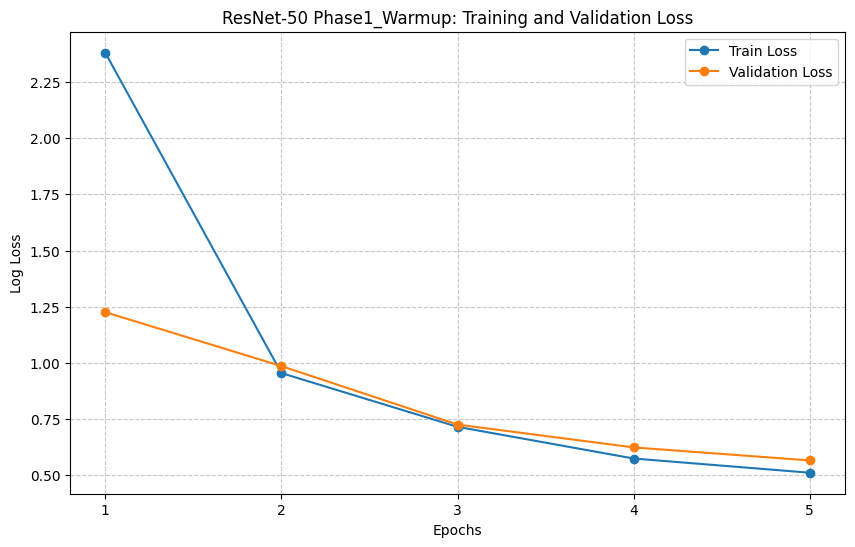

/tmp/ipykernel_1450/3746898841.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_filename))


In [6]:
# cell 6
# 僅訓練 model.fc (分類頭)
optimizer_phase1 = optim.AdamW(model.fc.parameters(), lr=LEARNING_RATE_PHASE1)

print("--- 開始第一階段訓練：只訓練分類頭 (熱身) ---")
model_phase1 = train_model(
    model,
    CRITERION,
    optimizer_phase1,
    scheduler=None,
    dataloader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS_PHASE1,
    phase="Phase1_Warmup",
    device=DEVICE,
)


--- 開始解凍整個 ResNet-50 骨幹 ---

--- 開始第二階段訓練：精細微調 (Fine-tuning) ---

--- Epoch 1/20 (Phase2_Finetune) ---



/home/jovyan/.conda/envs/pytorch_gpu_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4510 | Acc: 0.8587
Phase2_Finetune Train Loss: 0.3512
 -> 驗證 Loss 降低 (0.4510)，已保存模型到 resnet50_best_loss_Phase2_Finetune.pth！

--- Epoch 2/20 (Phase2_Finetune) ---



Epoch 2 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4456 | Acc: 0.8650
Phase2_Finetune Train Loss: 0.2728
 -> 驗證 Loss 降低 (0.4456)，已保存模型到 resnet50_best_loss_Phase2_Finetune.pth！

--- Epoch 3/20 (Phase2_Finetune) ---



Epoch 3 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4534 | Acc: 0.8582
Phase2_Finetune Train Loss: 0.2459

--- Epoch 4/20 (Phase2_Finetune) ---



Epoch 4 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4305 | Acc: 0.8660
Phase2_Finetune Train Loss: 0.2191
 -> 驗證 Loss 降低 (0.4305)，已保存模型到 resnet50_best_loss_Phase2_Finetune.pth！

--- Epoch 5/20 (Phase2_Finetune) ---



Epoch 5 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4312 | Acc: 0.8621
Phase2_Finetune Train Loss: 0.1937

--- Epoch 6/20 (Phase2_Finetune) ---



Epoch 6 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4149 | Acc: 0.8694
Phase2_Finetune Train Loss: 0.1800
 -> 驗證 Loss 降低 (0.4149)，已保存模型到 resnet50_best_loss_Phase2_Finetune.pth！

--- Epoch 7/20 (Phase2_Finetune) ---



Epoch 7 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4446 | Acc: 0.8670
Phase2_Finetune Train Loss: 0.1678

--- Epoch 8/20 (Phase2_Finetune) ---



Epoch 8 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4611 | Acc: 0.8582
Phase2_Finetune Train Loss: 0.1568

--- Epoch 9/20 (Phase2_Finetune) ---



Epoch 9 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4421 | Acc: 0.8675
Phase2_Finetune Train Loss: 0.1414

--- Epoch 10/20 (Phase2_Finetune) ---



Epoch 10 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4532 | Acc: 0.8636
Phase2_Finetune Train Loss: 0.1299

--- Epoch 11/20 (Phase2_Finetune) ---



Epoch 11 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4598 | Acc: 0.8631
Phase2_Finetune Train Loss: 0.1178

--- Epoch 12/20 (Phase2_Finetune) ---



Epoch 12 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4669 | Acc: 0.8597
Phase2_Finetune Train Loss: 0.1105

--- Epoch 13/20 (Phase2_Finetune) ---



Epoch 13 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4495 | Acc: 0.8587
Phase2_Finetune Train Loss: 0.1062

--- Epoch 14/20 (Phase2_Finetune) ---



Epoch 14 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4523 | Acc: 0.8689
Phase2_Finetune Train Loss: 0.0989

--- Epoch 15/20 (Phase2_Finetune) ---



Epoch 15 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4609 | Acc: 0.8601
Phase2_Finetune Train Loss: 0.0919

--- Epoch 16/20 (Phase2_Finetune) ---



Epoch 16 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4635 | Acc: 0.8650
Phase2_Finetune Train Loss: 0.0876

--- Epoch 17/20 (Phase2_Finetune) ---



Epoch 17 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4546 | Acc: 0.8641
Phase2_Finetune Train Loss: 0.0866

--- Epoch 18/20 (Phase2_Finetune) ---



Epoch 18 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4684 | Acc: 0.8572
Phase2_Finetune Train Loss: 0.0822

--- Epoch 19/20 (Phase2_Finetune) ---



Epoch 19 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4519 | Acc: 0.8641
Phase2_Finetune Train Loss: 0.0821

--- Epoch 20/20 (Phase2_Finetune) ---



Epoch 20 Phase2_Finetune:   0%|          | 0/512 [00:00<?, ?it/s]

Validation Log Loss: 0.4640 | Acc: 0.8592
Phase2_Finetune Train Loss: 0.0799


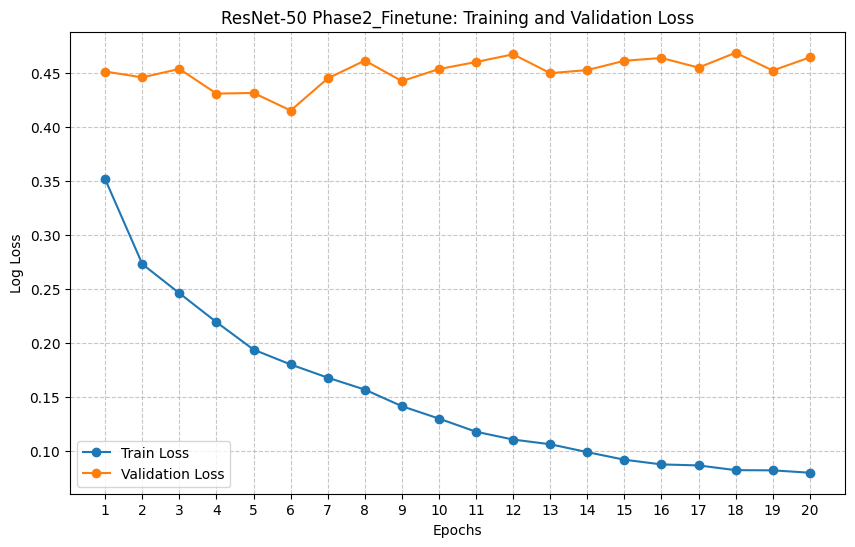

/tmp/ipykernel_1450/3746898841.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_filename))


In [7]:
# cell 7
# --- 1. 解凍整個模型 ---
print("\n--- 開始解凍整個 ResNet-50 骨幹 ---")
for param in model.parameters():
    param.requires_grad = True  # 所有層現在都可以訓練

# --- 2. 設置 Fine-tuning 優化器 ---
optimizer_phase2 = optim.AdamW(model.parameters(), lr=LEARNING_RATE_PHASE2)

# --- 3. 設置 ReduceLROnPlateau 排程器 (修正參數) ---
scheduler_phase2 = ReduceLROnPlateau(
    optimizer_phase2,
    mode="min",
    factor=0.5,  # 每次降低 50%
    patience=5,  # 修正為 5，避免過早降低 LR
    verbose=True,
)

# --- 4. 執行訓練 ---
print(f"\n--- 開始第二階段訓練：精細微調 (Fine-tuning) ---")

model_phase2 = train_model(
    model,
    CRITERION,
    optimizer_phase2,
    scheduler=scheduler_phase2,
    dataloader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS_PHASE2,
    phase="Phase2_Finetune",
    device=DEVICE,
)

In [8]:
# cell 8
# --- 最終推論與 CSV 生成 (修正 Log Loss 錯誤) ---

TEST_DIR = "dog-breed-identification (3)/test"
TEST_CSV_FILE = "dog-breed-identification (3)/sample_submission.csv"
RESNET_OUTPUT_FILE = "submission_resnet_fixed.csv"  # 新的修正後檔案名

# 1. 準備測試集的 DataLoader
test_df = pd.read_csv(TEST_CSV_FILE)
test_df["filepath"] = test_df["id"].apply(lambda x: os.path.join(TEST_DIR, f"{x}.jpg"))
test_df = test_df[["id", "filepath"]]


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data_frame = df
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx]["filepath"]
        image_id = self.data_frame.iloc[idx]["id"]
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, image_id


test_dataset = TestDataset(
    test_df, transform=val_transforms
)  # 使用 val_transforms (無隨機增強)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# 2. 執行推論
model.eval()
all_predictions = []

with torch.no_grad():
    for inputs, image_ids in tqdm(test_loader, desc="ResNet-50 推論中"):
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)

        # 轉換為 Softmax 機率 (必須的)
        probabilities = F.softmax(outputs, dim=1)

        # 儲存結果
        for image_id, probs in zip(image_ids, probabilities.cpu().numpy()):
            all_predictions.append([image_id] + probs.tolist())

# 3. 【關鍵修正】：獲取排序後的欄位標題
labels_df = pd.read_csv("dog-breed-identification (3)/labels.csv")
all_breeds = labels_df["breed"].unique()
breeds_sorted = sorted(all_breeds)  # <-- 確保按字母順序排序！

header = ["id"] + breeds_sorted

# 4. 寫入最終 CSV
with open(RESNET_OUTPUT_FILE, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)

    # 由於模型輸出的機率順序與編碼順序一致，且編碼順序與 sorted(all_breeds) 不一定一致
    # 我們需要重新整理輸出的機率，使其符合排序後的欄位。

    # 這裡我們需要使用編碼字典來對齊順序
    # (假設模型輸出的機率順序是根據 train_df 創建時的 'id' 順序)

    # 創建一個從 'id' (0-119) 到 'breed name' 的映射，然後排序。
    # 由於你的模型輸出機率是按照 {0: breed_A, 1: breed_B, ...} 的編碼順序，
    # 我們需要將這個順序重新映射到字母順序。

    # 這裡假設你的模型輸出機率矩陣的列 (column) 順序，對應的是 id_to_breed 的順序。

    # 構造一個從模型輸出索引 (0-119) 到 Kaggle 欄位索引的映射
    model_output_breeds = [id_to_breed[i] for i in range(NUM_CLASSES)]

    # 構造一個排序後的 Breed -> Model Index 的映射，幫助我們重新排列列
    kaggle_order_to_model_index = [
        model_output_breeds.index(breed) for breed in breeds_sorted
    ]

    for row in all_predictions:
        image_id = row[0]
        model_probs = np.array(row[1:])

        # 根據 Kaggle 要求的順序，重新排列機率
        kaggle_ordered_probs = model_probs[kaggle_order_to_model_index].tolist()

        writer.writerow([image_id] + kaggle_ordered_probs)

print(f"\n推論完成！已生成修正後的提交文件: {RESNET_OUTPUT_FILE}")

ResNet-50 推論中:   0%|          | 0/648 [00:00<?, ?it/s]


推論完成！已生成修正後的提交文件: submission_resnet_fixed.csv
